# Position Embeddings

## Why are they needed ?

Unlike an RNN/LSTM architecture which implicity factors in position, transformer architectures natively don't have a notion of position. Let's say you have a 512 token input sentence
What the transformer architecture learns is a 512 * 512 matrix of attention weights from the tokens, without factoring in position

(In fact , not having positional limitations is one of the key advantages of the transformer architure to capture long range dependencies, and not face problems like dimishing gradients which LSTMs have)

This problem was recognized in the first transformer paper (Attention is all you need) and they came with a concept of positional embeddings, where every position gets one vector/embedding



## Absolute position embeddings

The most common kind of positional embeddings, right from the first paper
Every position learns an absolute embedding

For example, If you have a 512 token input, indexed from 0 to 511
you will have position 0 learing one embedding vector of same dimension as token embedding, position 1 learning one embedding vector etc to get 512 learnt position embedding vectors, etc

These positional embeddings are added to the token embeddings, so some positional information is captured


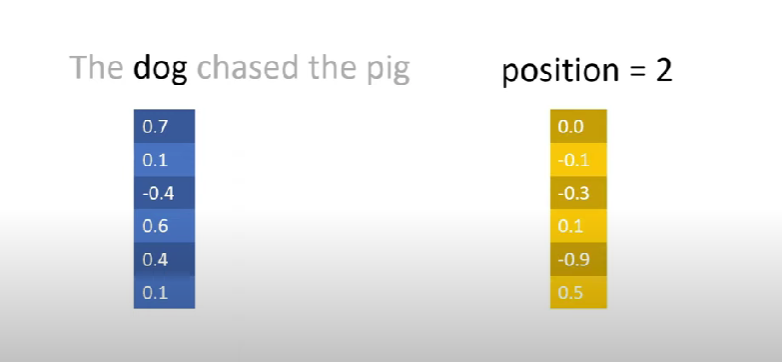

For example, if the token dog has the blue vector, the position 2 (1 in 0 indexing) has the yellow vector, so they are both added to get a representation of the word dog in position 2




## Obtaining absolute positional embeddings

Two ways - learnt, and sinusoidal/functional

### learnt positional embedding



Method 1 - Learnt from data - INitialize a position vector for every token (say 512) randomly. and allow them to be learnt

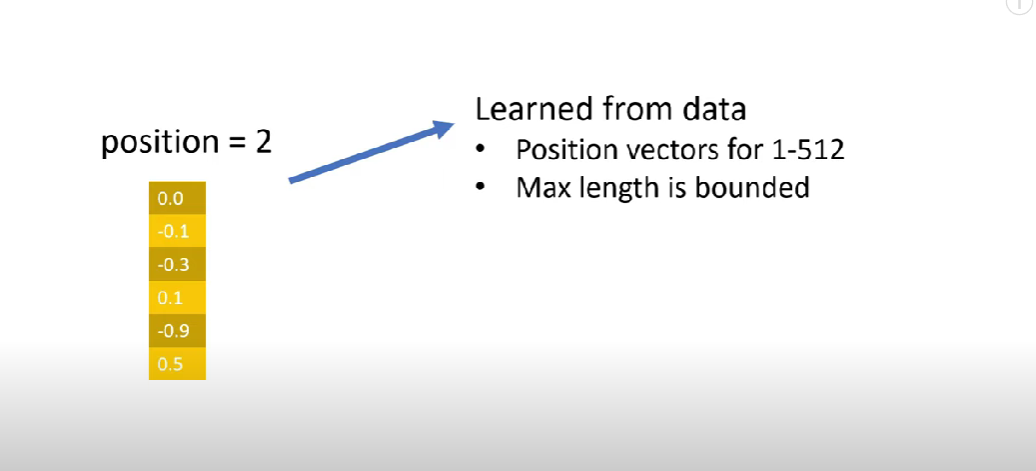

One disadvantage is that the max length is bounded. So if you want to get a position embedding of token 520 during inference/generation, when you have trained only 512 positional embeddings, you are stuck !!

Another disadvantage - they don't learn relative positional concepts. For example, there is a notion that 2 word gap, indepdent of whether the words are at position 2,4 or 3,5 ,etc mean something, that is not captured here

### sinusoidal positional embedding

This was actually used in the original attention paper. 
A static functional form was used, where for every position t, f(t) gave a d dimensional vector

What f should we chose ?

They chose a sin/cos

Why ?
https://kazemnejad.com/blog/transformer_architecture_positional_encoding/ has some intuition

If you want to represent integers 1 to T positions in binary

you would do something like this 

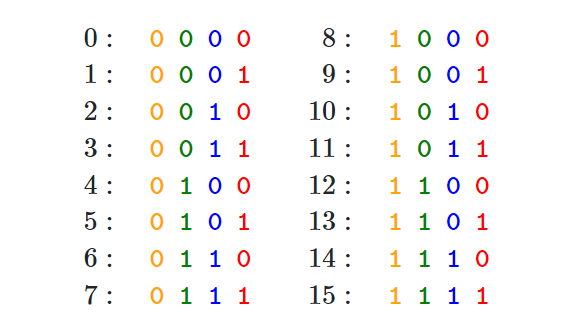

Note that this has an interesting property that the lowest significant bit is alternating every number, the next most significant bit is alternating every 2 nos and so on

So can we use a binary representation for position ? (0 represented by 0000, 1 represented by 0001 , and so on ? ) No, because we are working in the world of floats, and for every position, we want a vector of floats

One way to mimic the same behavior in the binary world above, in the float world is sinusoidal representations .


This is the choice used

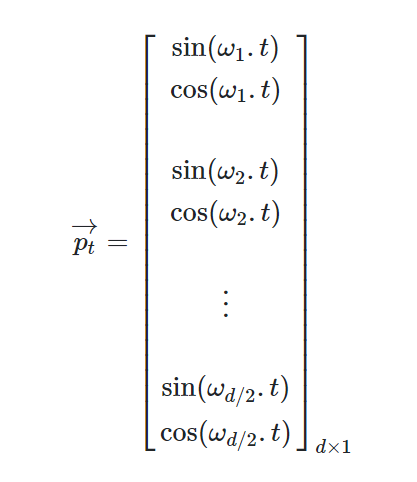

Where every position is represented by a d-dimensional static vector, every term in this static vector is given by alternating sin and cos of different frequencies

Note that every pair of positions (one sin and cos) have the same frequency, so if d is the desired positional embedding dimension, we need d/2 frequencies

wk was set to this
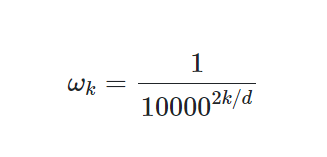

So the frequencies are decreasing along the vector dimension



This is how it visually looks like 

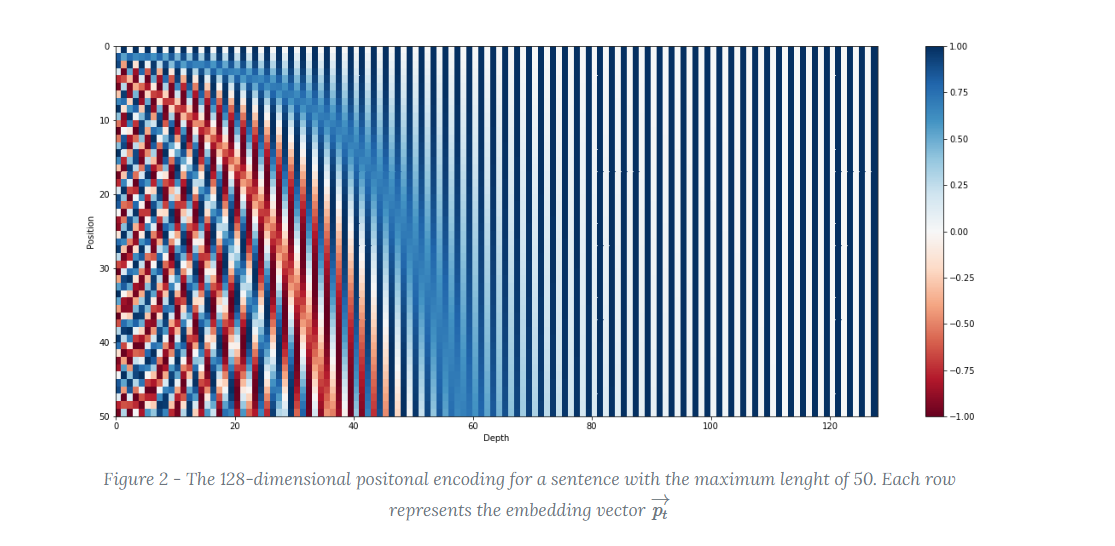

The advantages here are

1) These can be extended in generation time beyond the training token length used (unlike learnt absolute positional embeddings discussed above)

2) They capture absolute and relative positions (learnt absolute positional embeddings as discussed above don't do this)

How do they learn relative positions ?

Because of this property of sinusoidal functions

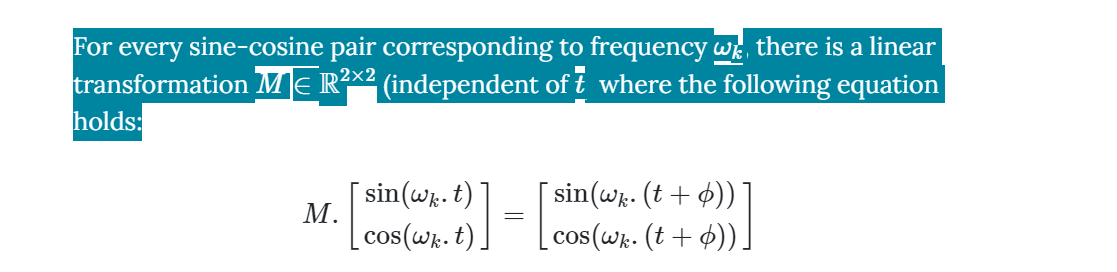

With a bit of algebra, (per link above https://kazemnejad.com/blog/transformer_architecture_positional_encoding) you can derive
M

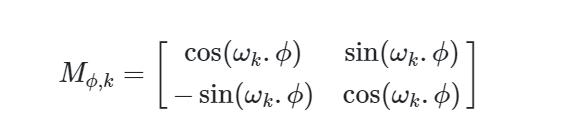

and it is indeed independent of T, in fact, it is like a rotation matrix

One disadvantage of this approach is that the positional embeddings are static, and not learnt from data



Emperically, both the above methods have similar performance

## Relative position embeddings

Used in T5 and other works. Unlike absolute positional embeddings discussed above which have an embedding for absolute positions, here we try to encode relative positions. This can't be done in the input stage unlike absolute positional embeddings, so a diff way needs to be chosen. Many variants of RPE, here  we discuss the T5 way

There are 
Each possible positional offset is represented by a bias, which is a floating point number

For example, Positional offset of 1 is represented by 0.23, positional offset of -1 is represented by 0.58, positional offset of 5 is represented by 2.3, etc

You get a matrix like this of T * T dimension of biases

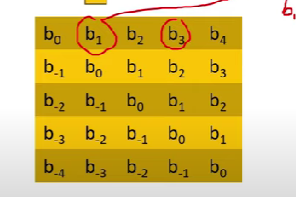


This can be added to the Q * K (T * T) logit matrix used for computing attention scores, and learnt



Advantage - handles relative positions, can extend to arbitrarily long sequences

Disadvantage - slower, during training and inference , as there is an additional addition step  in every forward pass which needs to be handled both in forward pass and during backprop

SPecifically during inference, every additional token needs you to regenerate the K,V matrices completely for all tokens seen thus far, you can't maintain a KV cache !! , so very slow

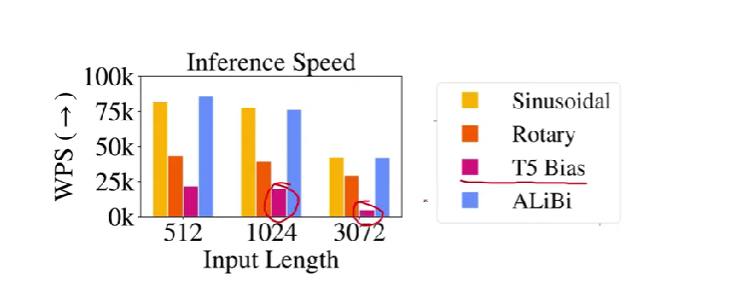



from this paper https://arxiv.org/pdf/2108.12409.pdf

## Rotary position embeddings

Recent (2023) positional embedding of choice - Used in GPT-J/Neo, LlAMA, PALM, etc

Key idea - instead of adding a positional vector to a token vector, you rotate the token vector instead

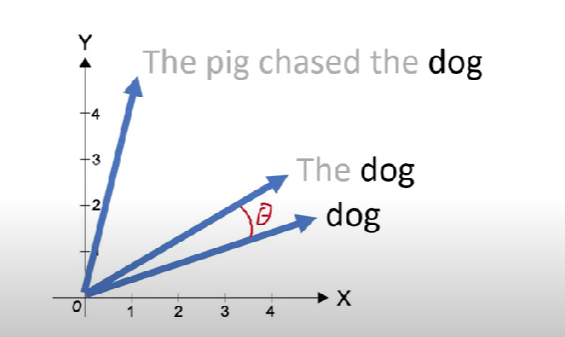

In the above diagram, lets say the arrow for dog is the token embedding for dog.
if you have "The dog", you rotate the token vector for dog
If you have "The pig chased the dog" you rotate the token vector even more 

The amount we rotate is an integer multiple of word position

So we rotate the original token vector by angle m * theta if the token is at position m in a sentence

This is the equation ( 2D for simplicity)

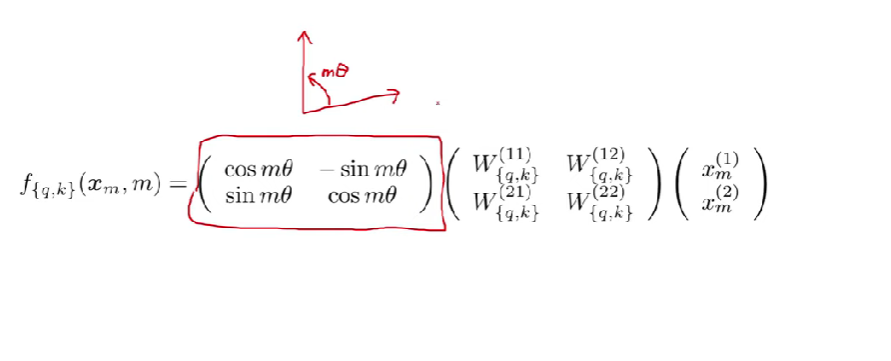


x is the token embedding in 2 dimensions here
m is the positionl , so you rotate by the highlighted rotation matrix

The matrix in between is the weight matrix to multiply x to get query and key vectors

So these rotations are applied on top of the query and key vectors (not the value , as value is obtained from query and key)

This is the more general d-dimensional equation

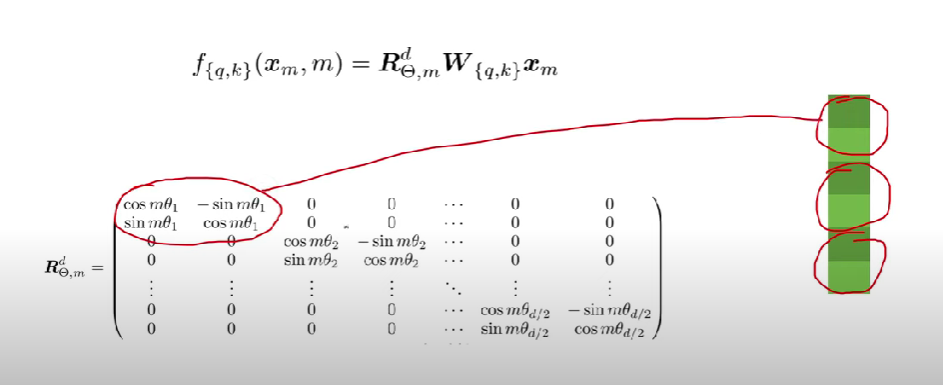

Notice that the rotation matrix is very sparse, and it operates on every two chunked dimensions separately (similar to the sinusoidal intution where you had 1 sin , 1 cos at frequency 1, 1 sin, 1 cos for frequency 2 and so on)

Since this is very sparse, for efficiency, there is a much faster implementation than constructing the matrix


This is the code

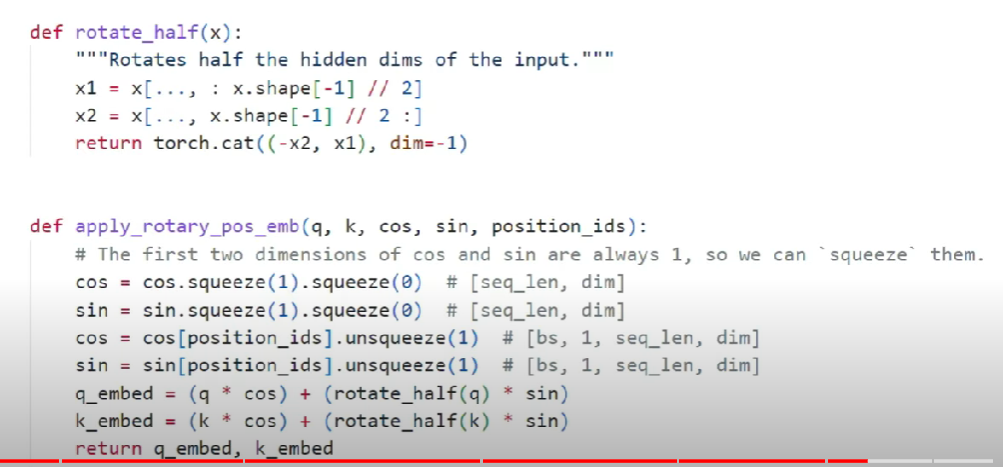


### RoPE - Results

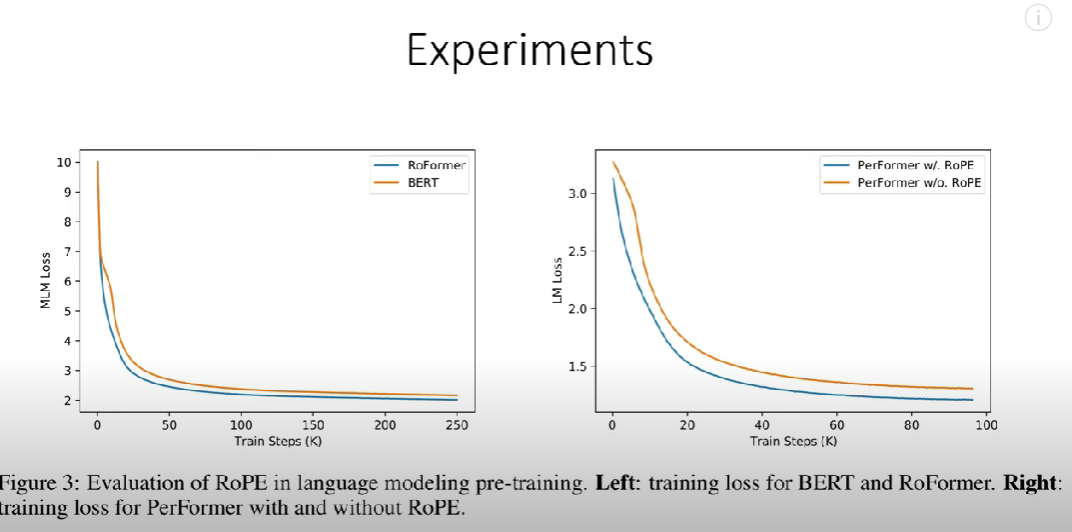

BERT and Roformer learnt faster, and reached a lower Loss with RoPE than without

### RoPE - advantages and disadvantages

Advantages - adding more tokens is ok (even out of context of training vector size), it just rotates more

You can do key value cache in inference time to improve speed, as the words positional embedding will not change on adding new words after it, it just depends on no of words before it

Relative positions of words are preserved

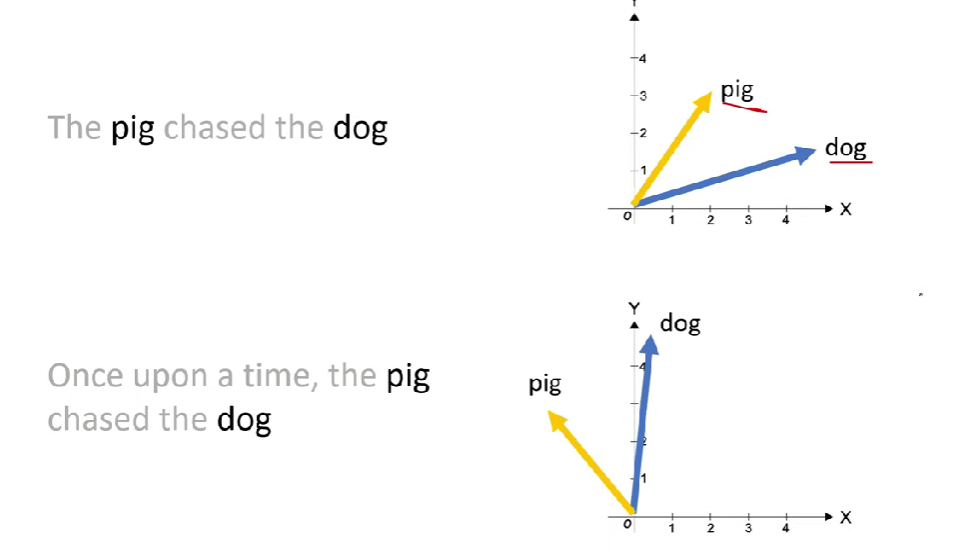






Another advantage, which is not there in the earlier methods discussed - when words are closer together, they have a larger dot product, when farther away, a smaller dot product

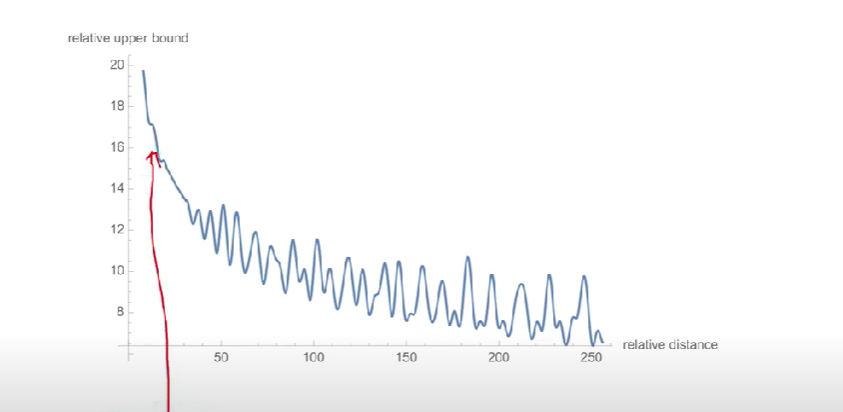

## References

1) https://www.youtube.com/watch?v=o29P0Kpobz0 - Very nice youtube video on ROPE
2) https://kazemnejad.com/blog/transformer_architecture_positional_encoding/ - A nice explanation of sinusoidal positional embedding